In [4]:
!pip install catboost

In [5]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
cancer_df = pd.read_csv('/content/drive/MyDrive/UT_Austin/AI_Healthcare/five-year-survival-rates-by-cancer-type.csv')
cancer_df.head()

,Entity,Code,Year,Breast,Cervix,Colon,Leukaemia,Liver,Lung,Ovary,Prostate,Rectum,Stomach
0,Algeria,DZA,1999,17.1,23.4,10.8,21.2,NaN,6.0,13.9,44.0,7.9,5.1
1,Algeria,DZA,2004,29.5,59.5,48.6,32.3,17.9,8.2,42.9,55.5,41.2,17.6
2,Algeria,DZA,2009,59.8,55.1,57.2,13.6,17.5,14.8,41.8,58.5,45.5,10.3
3,Argentina,ARG,2004,75.5,52.0,46.0,NaN,NaN,20.8,26.8,85.0,44.4,19.2
4,Argentina,ARG,2009,76.6,50.6,40.6,90.0,24.2,11.9,29.7,86.6,31.0,16.0


In [7]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Entity     159 non-null    object 
 1   Code       159 non-null    object 
 2   Year       159 non-null    int64  
 3   Breast     156 non-null    float64
 4   Cervix     154 non-null    float64
 5   Colon      152 non-null    float64
 6   Leukaemia  144 non-null    float64
 7   Liver      141 non-null    float64
 8   Lung       153 non-null    float64
 9   Ovary      149 non-null    float64
 10  Prostate   150 non-null    float64
 11  Rectum     144 non-null    float64
 12  Stomach    151 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 16.3+ KB


In [23]:
import pandas as pd
from catboost import CatBoostRegressor,Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
melted_df = pd.melt(cancer_df,id_vars=['Entity','Code','Year'],var_name='cancer_type',value_name='survival_rate')
#Drop missing values
melted_df = melted_df.dropna()
#features (X) and target(y)
X = melted_df[['cancer_type']]
y = melted_df[['survival_rate']]
#Map cancer types to numbers for Catboost
cancer_type_mapping = {value: name for name, value in zip(melted_df['cancer_type'],pd.factorize(melted_df['cancer_type'])[0])}
X['cancer_type'] = pd.factorize(X['cancer_type'])[0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
#Train model
model = CatBoostRegressor(iterations=100,learning_rate=0.1,depth=6,loss_function='RMSE')
train_pool = Pool(X_train,y_train,cat_features=['cancer_type'])
test_pool = Pool(X_test,y_test,cat_features=['cancer_type'])
model.fit(train_pool)

#Predict
predictions = model.predict(test_pool)
mse = mean_squared_error(y_test,predictions)
print(f"Mean Squared Error: {mse}")
mape = mean_absolute_percentage_error(y_test,predictions)
print(f"Mean Absolute Percentage Error {mape:.2f}")

0:	learn: 22.8957403	total: 1.23ms	remaining: 122ms
1:	learn: 21.4594151	total: 1.85ms	remaining: 90.8ms
2:	learn: 20.2241661	total: 2.44ms	remaining: 78.9ms
3:	learn: 19.1600646	total: 2.97ms	remaining: 71.3ms
4:	learn: 18.2054940	total: 3.51ms	remaining: 66.8ms
5:	learn: 17.3558021	total: 4.05ms	remaining: 63.4ms
6:	learn: 16.7101864	total: 4.56ms	remaining: 60.5ms
7:	learn: 16.1683729	total: 5.11ms	remaining: 58.8ms
8:	learn: 15.6532572	total: 5.63ms	remaining: 57ms
9:	learn: 15.2501914	total: 6.19ms	remaining: 55.7ms
10:	learn: 14.9406223	total: 6.52ms	remaining: 52.7ms
11:	learn: 14.6786237	total: 6.91ms	remaining: 50.7ms
12:	learn: 14.4474739	total: 7.43ms	remaining: 49.7ms
13:	learn: 14.2171205	total: 7.89ms	remaining: 48.5ms
14:	learn: 14.0644247	total: 8.33ms	remaining: 47.2ms
15:	learn: 13.9316587	total: 8.85ms	remaining: 46.4ms
16:	learn: 13.7777316	total: 9.38ms	remaining: 45.8ms
17:	learn: 13.6917414	total: 9.93ms	remaining: 45.2ms
18:	learn: 13.5878314	total: 10.5ms	remai

<ipython-input-23-f3f6b2211141>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cancer_type'] = pd.factorize(X['cancer_type'])[0]


In [25]:
#Results from CatBoost Regressor
#Evaluation
from tabulate import tabulate
from IPython.display import display,HTML
catboost_results_df = pd.DataFrame({'cancer_type': X_test['cancer_type'],
                           'predicted_survival_rate': predictions,
                           'actual_survival_rate': y_test['survival_rate']})
survival_rate_by_cancer = catboost_results_df.groupby('cancer_type').agg({'predicted_survival_rate': 'mean', 'actual_survival_rate': 'mean'})
survival_rate_by_cancer = survival_rate_by_cancer.reset_index()
survival_rate_by_cancer['cancer_type'] = survival_rate_by_cancer['cancer_type'].map(cancer_type_mapping)
survival_rate_by_cancer = survival_rate_by_cancer[['cancer_type','predicted_survival_rate','actual_survival_rate']]

#Rename columns
survival_rate_by_cancer = survival_rate_by_cancer.rename(
    columns={
        'cancer_type': 'Cancer Type',
        'predicted_survival_rate': 'Predicted Survival Rate',
        'actual_survival_rate': 'Actual Survival Rate'
    }
)
#Convert rates to percentages
survival_rate_by_cancer['Predicted Survival Rate'] = survival_rate_by_cancer['Predicted Survival Rate'].map('{:.2f}%'.format)
survival_rate_by_cancer['Actual Survival Rate'] = survival_rate_by_cancer['Actual Survival Rate'].map('{:.2f}%'.format)
#Display the results
title = "<h3> Results from CatBoost Regressor</h3>"
display(HTML(title))
#Format the table using CSS
table = tabulate(survival_rate_by_cancer,headers='keys',tablefmt='html',colalign=("left","right",'right'))
display(HTML("<style>th, td {padding: 0 15px; }</style>"+ table))

,Cancer Type,Predicted Survival Rate,Actual Survival Rate
0,Breast,71.79%,75.05%
1,Cervix,58.97%,59.03%
2,Colon,53.98%,50.77%
3,Leukaemia,39.36%,41.76%
4,Liver,21.65%,10.81%
5,Lung,21.65%,14.05%
6,Ovary,40.75%,37.44%
7,Prostate,74.76%,76.74%
8,Rectum,49.18%,51.66%
9,Stomach,26.45%,24.87%


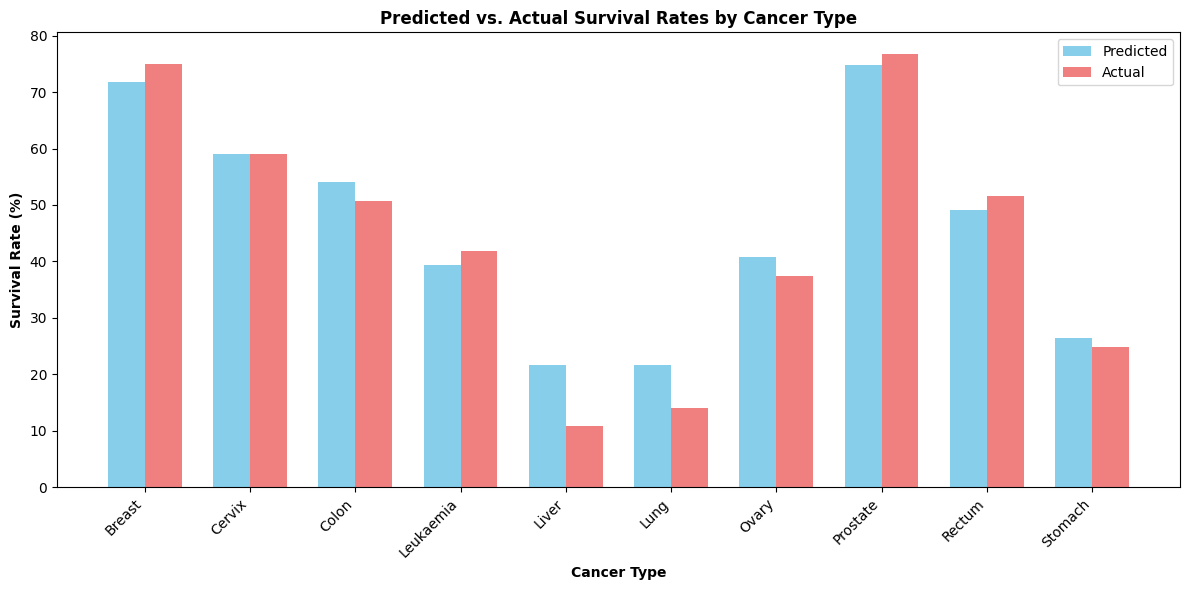

In [22]:
#Bar graph for catboost showing Predicted rate vs Actual
import matplotlib.pyplot as plt
import numpy as np
#Make survival rates numeric by removing the % sign
survival_rate_by_cancer['Predicted Survival Rate'] = pd.to_numeric(
    survival_rate_by_cancer['Predicted Survival Rate'].astype(str).str.rstrip('%'),
    errors='coerce'
)
survival_rate_by_cancer['Actual Survival Rate'] = pd.to_numeric(
    survival_rate_by_cancer['Actual Survival Rate'].astype(str).str.rstrip('%'),
    errors='coerce'
)


#Get unique values
cancer_type = survival_rate_by_cancer['Cancer Type'].unique()

#Plot bar graph
bar_width = 0.35
r1 = np.arange(len(cancer_type))
r2 = [x + bar_width for x in r1 ]
fig,ax = plt.subplots(figsize=(12,6))
ax.bar(r1,survival_rate_by_cancer['Predicted Survival Rate'],color='skyblue',width=bar_width,label='Predicted')
ax.bar(r2,survival_rate_by_cancer['Actual Survival Rate'],color='lightcoral',width=bar_width,label='Actual')

#Add labels and title
ax.set_xlabel('Cancer Type', fontweight='bold')
ax.set_ylabel('Survival Rate (%)', fontweight='bold')
ax.set_title('Predicted vs. Actual Survival Rates by Cancer Type', fontweight='bold')
ax.set_xticks([r + bar_width/2 for r in range(len(cancer_type))])
ax.set_xticklabels(cancer_type, rotation=45, ha='right')
#Add legend
ax.legend()

#Display bar chart
plt.tight_layout()


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.ensemble import AdaBoostRegressor
melted_df = pd.melt(cancer_df,id_vars=['Entity','Code','Year'],var_name='cancer_type',value_name='survival_rate')
melted_df = melted_df.dropna()
X = melted_df[['cancer_type']]
y = melted_df[['survival_rate']]
cancer_type_mapping = {value: name for name, value in zip(melted_df['cancer_type'],pd.factorize(melted_df['cancer_type'])[0])}
X['cancer_type'] = pd.factorize(X['cancer_type'])[0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
#Train model
model = AdaBoostRegressor(n_estimators=100,learning_rate=0.05,random_state=42)
model.fit(X_train,y_train.values.ravel())

#Predict
predictions = model.predict(X_test)
mse = mean_squared_error(y_test,predictions)
print(f"Mean Squared Error: {mse}")
mape = mean_absolute_percentage_error(y_test,predictions)
print(f"Mean Absolute Percentage Error {mape:.2f}")

<ipython-input-24-5692390844c0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cancer_type'] = pd.factorize(X['cancer_type'])[0]


Mean Squared Error: 134.20718325242063
Mean Absolute Percentage Error 0.49


In [46]:
#Results from AdaBoost Regressor
from tabulate import tabulate
from IPython.display import display,HTML
adaboost_results_df = pd.DataFrame({'cancer_type': X_test['cancer_type'],
                           'predicted_survival_rate': predictions,
                           'actual_survival_rate': y_test['survival_rate']})
survival_rate_by_cancer = adaboost_results_df.groupby('cancer_type').agg({'predicted_survival_rate': 'mean', 'actual_survival_rate': 'mean'})
survival_rate_by_cancer = survival_rate_by_cancer.reset_index()
survival_rate_by_cancer['cancer_type'] = survival_rate_by_cancer['cancer_type'].map(cancer_type_mapping)
survival_rate_by_cancer = survival_rate_by_cancer[['cancer_type','predicted_survival_rate','actual_survival_rate']]

#Rename columns
survival_rate_by_cancer = survival_rate_by_cancer.rename(
    columns={
        'cancer_type': 'Cancer Type',
        'predicted_survival_rate': 'Predicted Survival Rate',
        'actual_survival_rate': 'Actual Survival Rate'
    }
)
#Convert rates to percentages
survival_rate_by_cancer['Predicted Survival Rate'] = survival_rate_by_cancer['Predicted Survival Rate'].map('{:.2f}%'.format)
survival_rate_by_cancer['Actual Survival Rate'] = survival_rate_by_cancer['Actual Survival Rate'].map('{:.2f}%'.format)
#Display the results
title = "<h3> Results from AdaBoost Regressor</h3>"
display(HTML(title))
#Format the table using CSS
table = tabulate(survival_rate_by_cancer,headers='keys',tablefmt='html',colalign=("left","right",'right'))
display(HTML("<style>th, td {padding: 0 15px; }</style>"+ table))

,Cancer Type,Predicted Survival Rate,Actual Survival Rate
0,Breast,71.79%,75.05%
1,Cervix,58.97%,59.03%
2,Colon,53.98%,50.77%
3,Leukaemia,39.36%,41.76%
4,Liver,21.65%,10.81%
5,Lung,21.65%,14.05%
6,Ovary,40.75%,37.44%
7,Prostate,74.76%,76.74%
8,Rectum,49.18%,51.66%
9,Stomach,26.45%,24.87%
